**Classification and Captioning Aircraft Damage Using Pretrained Models**

This project is a part of IBM specialization " Introduction to Deep Learning and Neural Networks using Keras"

#Introduction

In this project, we will classify aircraft damage using a pre-trained VGG16 model and generate captions using a Transformer-based pretrained model.

Aircraft damage detection is essential for maintaining the safety and longevity of aircraft. Traditional manual inspection methods are time-consuming and prone to human error. This project aims to automate the classification of aircraft damage into two categories: "dent" and "crack." For this, we will utilize feature extraction with a pre-trained VGG16 model to classify the damage from aircraft images. Additionally, we will use a pre-trained Transformer model to generate captions and summaries for the images.

**Aim of the Project**

The goal of this project is to develop an automated model that accurately classifies aircraft damage from images. By the end of the project, you will have trained and evaluated a model that utilizes feature extraction from VGG16 for damage classification. This model will be applicable in real-world damage detection within the aviation industry. Furthermore, the project will showcase how we can use a Transformer-based model to caption and summarize images, providing a detailed description of the damage.

**Final Output**

A trained model capable of classifying aircraft images into "dent" and "crack" categories, enabling automated aircraft damage detection.
A Transformer-based model that generates captions and summaries of images

# Tasks

To achieve the above objectives, we will complete the following tasks:

Task 1: Create a valid_generator using the valid_datagen object

Task 2: Create a test_generator using the test_datagen object

Task 3: Load the VGG16 model

Task 4: Compile the model

Task 5: Train the model

Task 6: Plot accuracy curves for training and validation sets

Task 7: Visualizing the results

Task 8: Implement a Helper Function to Use the Custom Keras Layer

Task 9: Generate a caption for an image using the using BLIP pretrained model

Task 10: Generate a summary of an image using BLIP pretrained model

#Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Importing Essential Libraries

In [3]:
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [4]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Pretrained Model

A pretrained model refers to a machine learning model that has already been trained on a large dataset, typically for a specific task, and is ready for use or fine-tuning on a new task or dataset. The key idea behind a pretrained model is that it has already learned useful patterns or features from the data it was trained on, so you don’t need to start from scratch.

**ResNet, VGG (Image Classification)**: These are pretrained models commonly used for image classification tasks. They have learned from millions of images and can be fine-tuned for specific image-related tasks.

**BLIP (Image Captioning and Summarization)**: BLIP is a pretrained model that can generate captions and summaries for images. It has already been trained on image-text pairs, so it can easily generate descriptive captions for new images.

# Part 1 - Classification Problem: Classifying the defect on the aircraft as 'dent' or 'crack'

## 1.1 Dataset Preparation

In [5]:
# define some model configuration options

batch_size=32
n_epochs=5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

In [6]:
# Extract the Dataset: Unzip the dataset to the current directory, creating directories for training, testing, and validation splits.

import tarfile
import urllib.request
import os
import shutil

# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

# Define the path to save the file
tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now.")

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")

    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")




Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now.
Extracted aircraft_damage_dataset_v1.tar successfully.


In [7]:
# Define directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

## 1.2 Data Preprocessing

Create data generators for training, validation, and testing datasets.

First,we will create **ImageDataGenerators** used for training, validation and testing. The ImageDataGenerator class is part of Keras. It is a powerful utility for real-time image **data augmentation, preprocessing, and feeding data into deep learning models during training**. This class is particularly useful when working with image datasets that are too large to fit into memory all at once, or when you want to augment your dataset to improve model generalization.

We will create instances of the ImageDataGenerator class. Each instance corresponds to one of the datasets: training, validation, and testing.

In [8]:
# Create ImageDataGenerators to preprocess the data

train_datagen=ImageDataGenerator(rescale=1./255)
valid_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

Next, we use **flow_from_directory()** method to load the images from directory and generate the training dataset. The flow_from_directory() method is part of the ImageDataGenerator class in Keras, and it plays a crucial role in automating the process of loading, preprocessing, and batching images for training, validation, and testing. We use the train_datagen object to load and preprocess the training images. Specifically, the flow_from_directory() function is used to read images directly from the directory and generate batches of data that will be fed into the model for training.

In [9]:
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows,img_cols),   #VGC16 expects 224*224*3
    color_mode='rgb',
    batch_size=batch_size,
    seed=seed_value,
    class_mode='binary',
    shuffle=True
)

Found 300 images belonging to 2 classes.


In [10]:
valid_generator =  valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols),
    color_mode='rgb'
)

Found 96 images belonging to 2 classes.


In [11]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows,img_cols)
)

Found 50 images belonging to 2 classes.


## 1.3 Model Definition

Here, we define the model architecture by using a pre-trained VGG16 model as the base, adding custom layers on top for binary classification of 'dent' and 'crack' types of damage.

In [12]:
base_model = VGG16(weights='imagenet' , include_top=False , input_shape=(img_rows, img_cols, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Now, we modify the VGG16 model for our specific classification task. We extract the output from the last layer of the pre-trained VGG16 model, and then create a new model with this modified output. Then we will freeze the base VGG16 model layers so that their weights will not be updated during training.


In [13]:
output=base_model.layers[-1].output
output=keras.layers.Flatten()(output)

base_model=Model(base_model.input,output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

After using VGG16 as a feature extractor, we add our own classifier on top of the VGG16 model. This involves adding fully connected layers (Dense), activation functions (like ReLU), and sometimes Dropout layers to avoid overfitting. Here, we are adding two dense layers with 512 units each, followed by a Dropout layer, and finally, a Dense layer with one unit and a sigmoid activation to output the probability for binary classification ("dent" vs "crack").

In [14]:
#define fully connected later part of model

model=Sequential()
model.add(base_model)
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

In [15]:
# compile the model

model.compile(
    optimizer=(Adam(learning_rate=0.0001)),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## 1.4 Model Training

In [16]:
model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=valid_generator
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 987ms/step - accuracy: 0.4879 - loss: 0.7515 - val_accuracy: 0.5938 - val_loss: 0.6335
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.6958 - loss: 0.5540 - val_accuracy: 0.6771 - val_loss: 0.5771
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.7314 - loss: 0.4966 - val_accuracy: 0.6979 - val_loss: 0.5429
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.8187 - loss: 0.3778 - val_accuracy: 0.6771 - val_loss: 0.5874
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.8060 - loss: 0.3770 - val_accuracy: 0.7292 - val_loss: 0.4732


In [17]:
# Access the training history
train_history = model.history.history  # After training
train_history

{'accuracy': [0.5166666507720947,
  0.7099999785423279,
  0.75,
  0.8033333420753479,
  0.8399999737739563],
 'loss': [0.7158749103546143,
  0.5401118993759155,
  0.4718635082244873,
  0.39555978775024414,
  0.3493446409702301],
 'val_accuracy': [0.59375,
  0.6770833134651184,
  0.6979166865348816,
  0.6770833134651184,
  0.7291666865348816],
 'val_loss': [0.6334586143493652,
  0.5771005749702454,
  0.5429273247718811,
  0.5873791575431824,
  0.4731781482696533]}

## 1.6 Visualizing Training Results

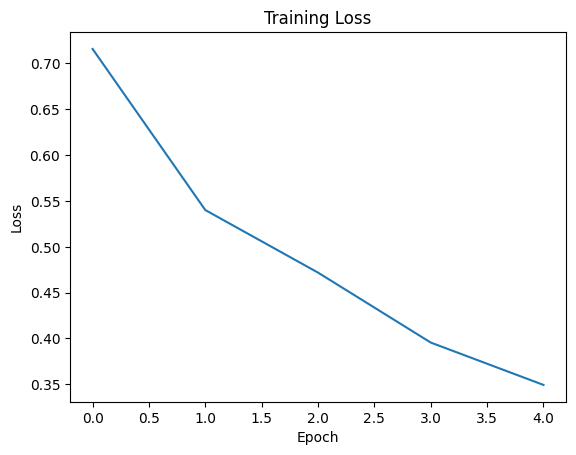

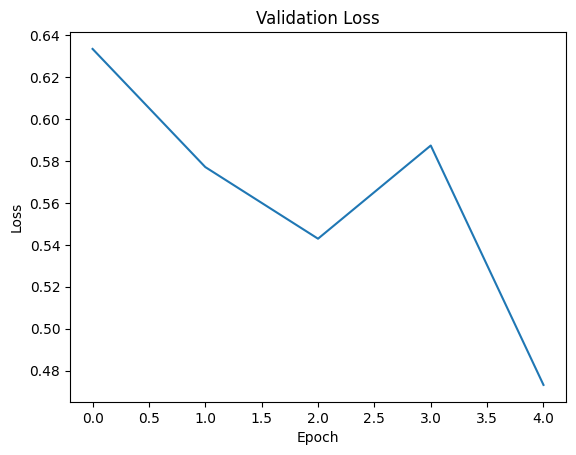

In [18]:
# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 25088)               │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,040,901 (206.15 MB)

 Trainable params: 13,108,737 (50.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 26,217,476 (100.01 MB)

In [20]:
print(model.optimizer)  # Shows optimizer details
print(model.loss)       # Shows loss function used
print(model.metrics)    # Shows list of metrics used

binary_crossentropy
[<Mean name=loss>, <CompileMetrics name=compile_metrics>]


In [21]:
print(model.optimizer.get_config())  # Shows learning rate, momentum, etc.

{'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


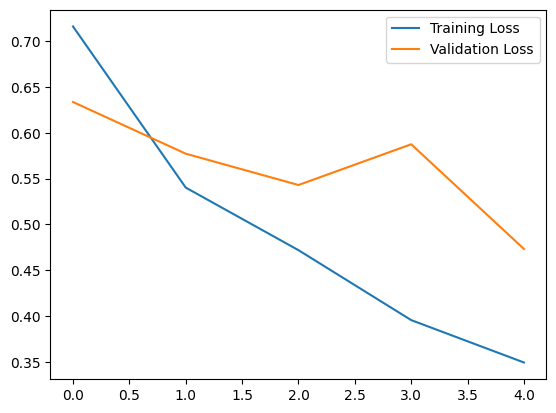

Final Training Loss: 0.3493446409702301
Final Validation Loss: 0.4731781482696533


In [22]:
# Plot loss curve
plt.plot(train_history['loss'], label='Training Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Print last epoch loss & accuracy
print("Final Training Loss:", train_history['loss'][-1])
print("Final Validation Loss:", train_history['val_loss'][-1])

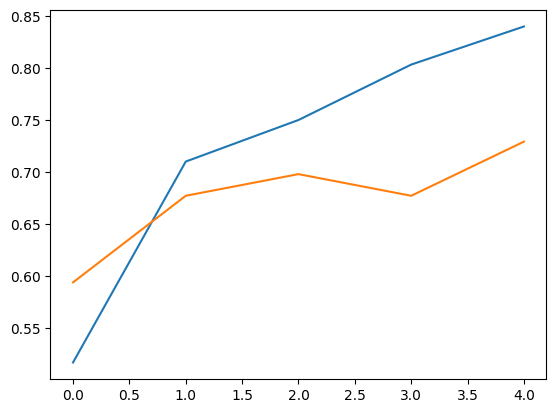

In [23]:
figsize=(5, 5)
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')

## 1.7 Model Evaluation

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)))

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 7s/step - accuracy: 0.8308 - loss: 0.4936
Test Loss: 0.4770
Test Accuracy: 0.8400


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step


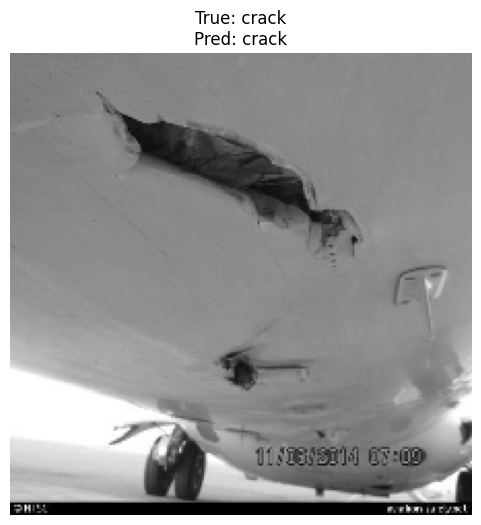

In [26]:
test_model_on_image(test_generator, model, index_to_plot=15)

# Part 2: Image Captioning and Summarization using BLIP Pretrained Model

BLIP (**Bootstrapping Language-Image Pretraining**) is an advanced vision-and-language model designed to generate natural language descriptions for images. By leveraging both visual and textual information, BLIP can produce human-readable text that accurately reflects the content and context of an image. It is specifically trained to understand images and their relationships to summarizing text, making it ideal for tasks like image captioning, summarization, and visual question answering.

The code will integrate the BLIP model within a custom Keras layer. This allows the user to input an image and specify a task, either "caption" or "summary", to receive a textual output that describes or summarizes the content of the image.

Key Steps:

**Image Loading and Preprocessing**: The code will begin by loading images from a file path, then converting and processing them into a format suitable for input to the BLIP model.

**Text Generation**: Depending on the task, whether generating a caption or summary, the BLIP model will generate corresponding text based on the processed image.

**Custom Keras Layer**: A custom Keras layer is a user-defined layer that extends Keras' built-in functionality.Here custom Keras layer will be implemented to wrap the BLIP model. This layer will handle the task-specific processing (captioning or summarizing) and integrate smoothly into a TensorFlow/Keras environment.

In [27]:
#Load the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

## 2.1 Load BLIP Model

Hugging Face is an open-source platform that provides pre-trained machine learning models, datasets, and tools, primarily focused on natural language processing, computer vision, and other AI tasks. It offers easy access to powerful models through its Transformers library.

**BlipProcessor**: This handles the preprocessing of images and text. It converts images to the format that the BLIP model can understand.

**BlipForConditionalGeneration**: This is the model itself, responsible for generating captions or summaries based on the processed image.

In [28]:
#load the pretrained BLIP processor and model:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

**Custom Keras Layer:** BlipCaptionSummaryLayer

Next, we define a custom tf.keras.layers.Layer class that takes in an image and a task input (either caption or summary) and processes the image using the BLIP model. To create a custom Keras layer, we need to subclass tf.keras.layers.Layer and implement the required methods.

**BlipCaptionSummaryLayer** Class:
This custom Keras layer integrates image preprocessing and text generation using a pretrained BLIP model.

__init__: This constructor method initializes the BlipCaptionSummaryLayer class by setting up the BLIP processor and model.

**call**: This method defines the operations or transformations applied to the input data as it passes through the layer.

**process_image**: The process_image method contains the custom logic for loading the image, preprocessing it, generating the text (either a caption or a summary) using the BLIP model, and returning the generated result.

In [29]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"


Create the Helper Function generate_text:
The function will accept following parameters:

**image_path**: The path to the image file (in tensor format).

**task**: The type of task to perform, which can either be "caption" or "summary" (in tensor format).
Inside the function:

1. Create an instance(blip_layer) of the BlipCaptionSummaryLayer.

2. Call this layer with the provided image path and task type.

3. Return the generated caption or summary as the output.

In [30]:
# Define a helper function to use the custom Keras layer
def generate_text(image_path, task):
  # Create an instance of the custom Keras layer
  # Replace this with the pretrained BLIP processor and model loaded earlier
    blip_layer = BlipCaptionSummaryLayer(processor, model)
    # Call the layer with the provided inputs
    return blip_layer(image_path, task)

## 2.2 Generating Captions and Summaries

Now we use the generate_text function to generate a caption and a summary for an image. It processes the image and prints the corresponding text output in a human-readable format. The function makes it easy to switch between generating captions and summaries based on the task type you provide.

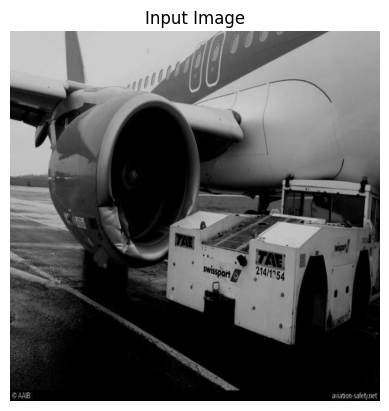

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


In [32]:
# Path to an example image
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Convert TensorFlow tensor to a Python string for displaying the image
image_path_str = image_path.numpy().decode("utf-8")

# Open and display the image
image = Image.open(image_path_str).convert("RGB")
plt.imshow(image)
plt.axis("off")  # Hide axes for better visualization
plt.title("Input Image")
plt.show()

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

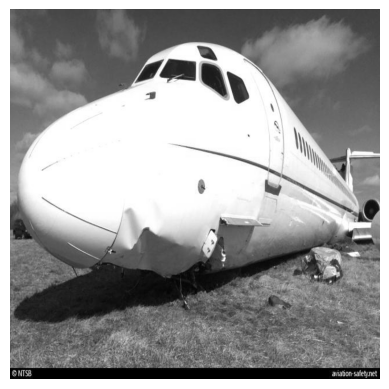

In [33]:
# We will use the following image to display Caption and Summary
# URL of the image
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
# Load and display the image
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [36]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")
generate_text(image_path, tf.constant("caption"))

<tf.Tensor: shape=(), dtype=string, numpy=b'this is a picture of a plane that was sitting on the ground in a field'>

In [37]:
generate_text(image_path, tf.constant("summary"))

<tf.Tensor: shape=(), dtype=string, numpy=b'this is a detailed photo showing the damage to the fuselage of the aircraft'>